In [2]:

#PLEASE MAKE SURE YOU ARE RUNNING IN AN APACHE SPARK NOTEBOOK/RUNTIME

import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '6aaf54352357483486ee2d4981f8ef15',
    'region': 'dallas',
    'user_id': 'e8a574f22ee84d29b7a1987b6103fced',
    'username': 'member_adcb54bd899a7e39e31582bccad1577f68f1992f',
    'password': 'P*/m8,!#7s6H9poz'
}

configuration_name = 'os_d3bd5b94a9334de59a55a7fed2bedeaa_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


In [3]:
df_healthy = spark.read.parquet(bmos.url('courseraai', 'cwr_healthy.parquet'))
df_healthy.createOrReplaceTempView('df_healthy')

In [4]:
df_faulty = spark.read.parquet(bmos.url('courseraai', 'cwr_faulty.parquet'))
df_faulty.createOrReplaceTempView('df_faulty')

In [5]:
df_healthy = df_healthy.repartition(1)

In [6]:
df_healthy.write.csv('cwr_healthy.csv')

In [7]:
df_faulty = df_faulty.repartition(1)

In [8]:
df_faulty.write.csv('cwr_faulty.csv')

In [21]:
import pandas as pd
df_healthy = pd.read_csv('cwr_healthy.csv/part-00000-c08ced3c-6ac7-4da9-be74-33077e7844b5.csv', engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,382259,98,-0.111609,0.121629
1,382260,98,-0.090956,0.130258
2,382261,98,-0.044852,0.088140
3,382262,98,-0.028163,0.064718
4,382263,98,-0.042975,0.064307


In [25]:
df_healthy.loc[df_healthy[1] == 100]

,0,1,2,3
538023,727841,100,0.192922,0.014603
538024,727842,100,0.164364,0.054449
538025,727843,100,0.090811,0.107646
538026,727844,100,0.086496,0.133722
538027,727845,100,0.099235,0.112652
538028,727846,100,0.093071,0.082403
538029,727847,100,0.081976,0.086993
538030,727848,100,0.033078,0.110566
538031,727849,100,0.011711,0.127673
538032,727850,100,0.022189,0.113487


In [52]:
df_faulty = pd.read_csv('cwr_faulty.csv/part-00000-c2e8517c-6eac-49f5-aa75-113101621aa7.csv', engine='python', header=None)
df_faulty.head()

,0,1,2,3
0,6500236,210,-0.006575,1.787193
1,6500237,210,0.073964,-0.153501
2,6500238,210,0.214700,-1.783944
3,6500239,210,0.119780,-0.006903
4,6500240,210,0.015820,1.621509


In [48]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

Using TensorFlow backend.


In [8]:
def get_recording(df,file_id):
    return np.array(df.orderBy(df['_c0']).where(df['_c1'] == file_id).select('_c2','_c3').rdd.map(lambda row: np.array([row._c2,row._c3])).collect())  


In [54]:
def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))


In [8]:

from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_adcb54bd899a7e39e31582bccad1577f68f1992f','domain': {'id': '4619da2fa8524beda11c89d2d1969c5b'},
            'password': 'P*/m8,!#7s6H9poz'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa('courseraai', 'cwr_healthy.csv/part-00000-2fe5401d-6223-4931-880e-634da433b039.csv-attempt_20180202060424_0005_m_000000_0'))
df_data_1.head()


,<html><h1>Not Found</h1><p>The resource could not be found.</p></html>


In [55]:
import numpy as np
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,125)

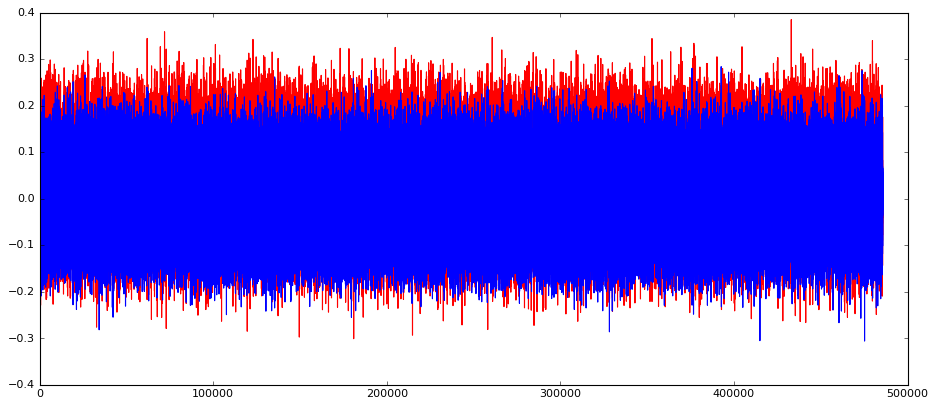

In [50]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)

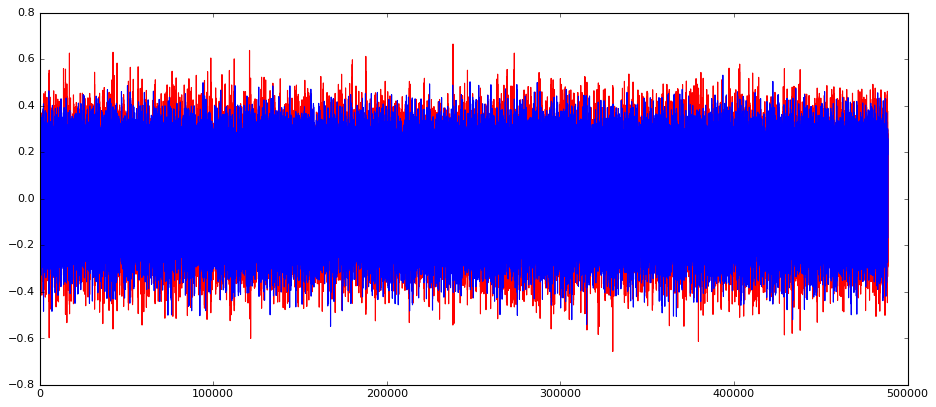

In [56]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)

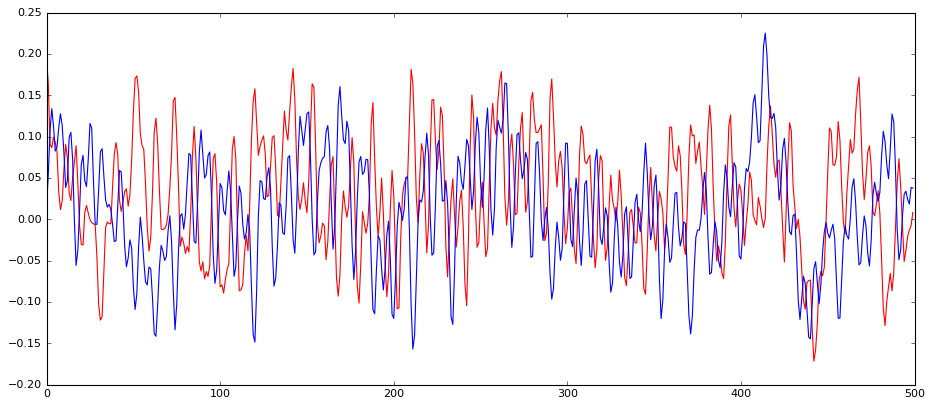

In [57]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

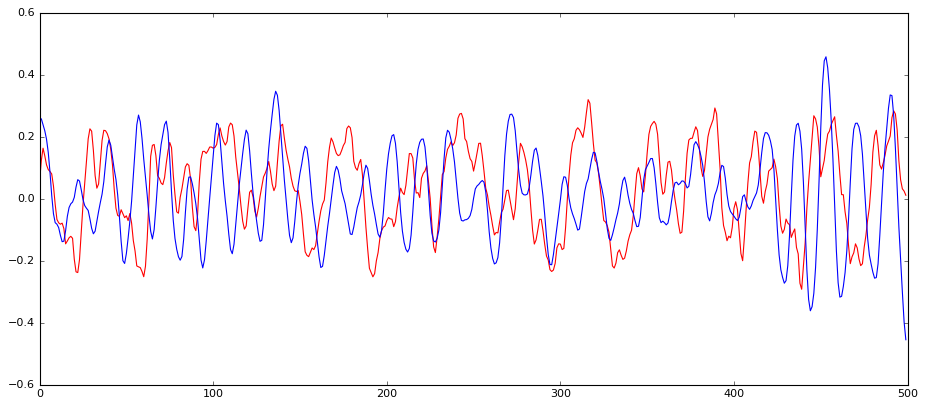

In [58]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

In [59]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [ ]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


In [18]:
def create_trimmed_recording(df,file_id):
    recording = np.array(df.orderBy(df['_c0']).where(df['_c1'] == file_id).select('_c2','_c3').rdd.map(lambda row: np.array([row._c2,row._c3])).collect())  
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (samples/timesteps,timesteps,dim)
    return recording_trimmed

In [61]:
def create_trimmed_recording(df,file_id):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (samples/timesteps,timesteps,dim)
    return recording_trimmed


In [68]:
#pd.unique()
#df_healthy.drop(0,1).drop(2,1).drop(3,1)
pd.unique(df_healthy.iloc[:,1])

array([ 98,  97, 100])

In [ ]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id)
    print "Staring training on %s" % (file_id)
    train(recording_trimmed)
    print "Finished training on %s after %s seconds" % (file_id,time.time()-start)

print "Finished job on after %s seconds" % (time.time()-start)
healthy_losses = lossHistory.losses


Staring training on 98
Finished training on 98 after 177.781706095 seconds
Staring training on 97
Finished training on 97 after 269.112179995 seconds
Staring training on 100


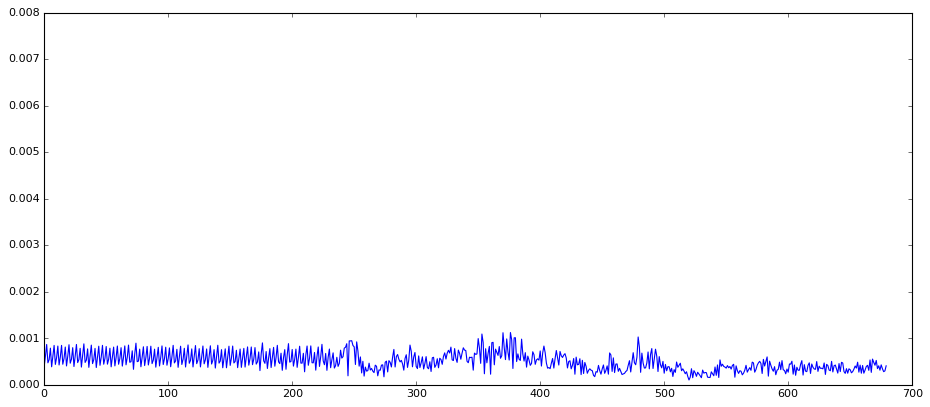

In [20]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [21]:
#file_ids = spark.sql('select distinct _c1 from df_healhty').rdd.map(lambda row : row._c1).collect()
start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print "Staring training on %s" % (file_id)
    train(recording_trimmed)
    print "Finished training on %s after %s seconds" % (file_id,time.time()-start)

print "Finished job on after %s seconds" % (time.time()-start)
faulty_losses = lossHistory.losses

Staring training on 105
Finished training on 105 after 92.8888118267 seconds
Finished job on after 92.8902578354 seconds


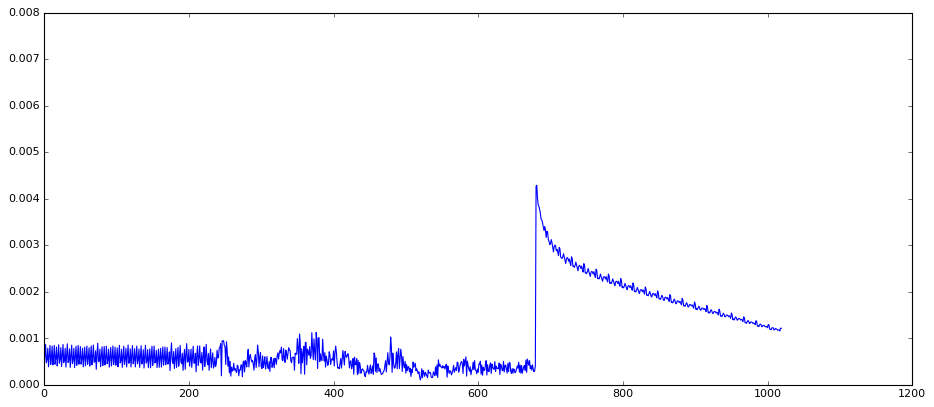

In [22]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)